In [1]:

import os
import xarray as xr
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs # => to add in Seastar env
import seastar as ss
from seastar.utils.tools import dotdict
from scipy import interpolate, stats # => to add in Seastar env ?
from scipy.optimize import least_squares
import matplotlib.patches as mpatches
# from seastar.gmfs.doppler import *
import pdb

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
Framework to provide ESA with a 'unit test' of sorts. For example, apply different noise levels to the performance
evaluation code sequentially to look at the RMS (or RMedS, or BSS, or some other statistical metric) of the retrieved
parameters with respect to the noise level.

TODO:
    Re-run with more data points
    Lay out method and talk to Adrien and Christine about the framework
    

# L1 and geo input datasets

In [4]:
along_length = 5
across_length = 5
level1 = xr.Dataset(
    data_vars=dict(
            CentralWavenumber=( [],270 ),
            CentralFreq=( [], 13.5 * 10**9 ),
            IncidenceAngleImage=(['along','across','Antenna'],
                     np.stack((np.full([along_length, across_length], 36.5),
                              np.full([along_length, across_length], 28.4),
                              np.full([along_length, across_length], 36.5)
                              ),axis=-1
                             )
                    ),
            AntennaAzimuthImage=(['along','across', 'Antenna'],
                           np.stack((np.full([along_length, across_length], 45),
                                     np.full([along_length, across_length], 90),
                                     np.full([along_length, across_length], 135)
                                     ), axis=-1)
                                ),
            Polarization=(['along','across','Antenna'],
                          np.stack((np.full([along_length, across_length], 'VV'),
                                    np.full([along_length, across_length], 'VV'),
                                    np.full([along_length, across_length], 'VV')
                                    ), axis=-1)
                         ),
    ),
    coords=dict(
            along=np.arange(0,along_length),
            across=np.arange(0,across_length),
            Antenna=['Fore','MidV','Aft'],
        ),
)
level1 = level1.set_coords([
    'CentralWavenumber','CentralFreq','IncidenceAngleImage','AntennaAzimuthImage','Polarization', 
])
geo = xr.Dataset(
        data_vars=dict(
            WindSpeed=(['along','across'], np.full([along_length, across_length], 5.)), #5m/s
            WindDirection=(['along','across'], np.full([along_length, across_length], 270.)), #0 degrees
            CurrentVelocity=(['along','across'], np.full([along_length, across_length], 0.6)), #0.6m/s
            CurrentDirection=(['along','across'], np.full([along_length, across_length], 150.)), 
        ),
        coords=dict(
            along=np.arange(0, along_length),
            across=np.arange(0,across_length),
        ),
    )
geo['EarthRelativeWindSpeed'] = geo.WindSpeed
geo['EarthRelativeWindDirection'] = geo.WindDirection
ss.utils.tools.EarthRelativeSpeedDir2all(geo)
geo['WindSpeed'] = geo.OceanSurfaceWindSpeed
geo['WindDirection'] = geo.OceanSurfaceWindDirection

gmf = {'doppler':{'name':'mouche12'}, 'nrcs':{'name':'nscat4ds'}}
level1['Sigma0'] = ss.gmfs.nrcs.compute_nrcs(level1, geo, gmf['nrcs']).T

model_rsv_list = [None] * level1.Antenna.size
model_wasv_list = [None] * level1.Antenna.size
for aa, ant in enumerate(level1.Antenna.data):
    model_rsv_list[aa] = ss.gmfs.doppler.compute_total_surface_motion(level1.sel(Antenna=ant),
                                                                      geo,
                                                                      gmf=gmf['doppler']['name'])
level1['RSV'] = xr.concat(model_rsv_list, dim='Antenna').T

In [5]:
level1

<xarray.Dataset>
Dimensions:              (along: 5, across: 5, Antenna: 3)
Coordinates:
    CentralWavenumber    int32 270
    CentralFreq          float64 1.35e+10
    IncidenceAngleImage  (along, across, Antenna) float64 36.5 28.4 ... 36.5
    AntennaAzimuthImage  (along, across, Antenna) int32 45 90 135 ... 45 90 135
    Polarization         (along, across, Antenna) <U2 'VV' 'VV' ... 'VV' 'VV'
  * along                (along) int32 0 1 2 3 4
  * across               (across) int32 0 1 2 3 4
  * Antenna              (Antenna) <U4 'Fore' 'MidV' 'Aft'
Data variables:
    Sigma0               (Antenna, along, across) float64 0.007902 ... 0.007225
    RSV                  (Antenna, along, across) float64 0.3177 ... 0.9914

# Define noise

Have a look on the server in truths
have a look at seastar.performance.scene_generation.uncertainty_fct
seastar.performance.scene_generation.noise_generation

Run L2[ii] = ss.retrieval.level2.wind_current_retrieval(level1, noise, gmf, ambiguity) without ambiguity and then
solve ambiguity afterwards
Use 'closest to truth'
seastar.retrieval.ambiguity_removal.solve_ambiguity(level2, ambiguity_dict)
amb_dict = {'name': 'closest_truth', 'truth': truth, 'method': 'current'}

Different noise levels for sigma 0 and rsv
'Default' noise for Sigma0 ~ 0.001
For RSV 0.01

Step through noise levels by factors of 10, so something like:
    Sigma0 = 0.001, 0.01, 0.05, 0.1
    RSV = 0.01, 0.1, 0.3, 1
Noise on the Mid beam:
    RSV = constant of 1m/s
    Sigma0 = same as squinted beams

In [5]:
# Set standard RSV to 5cm/s
# Set standard Kp of 3%

In [ ]:
pdb.set_trace()
noise_RSV_list = [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]
noise_sigma0_list = [0.001, 0.01, 0.02, 0.03, 0.04, 0.05]
ambiguity = {'name':'closest_truth', 'truth':geo, 'method': 'current'}
#ambiguity = {'name':'sort_by_cost'}
baseline_RSV_noise = 0.05
baseline_sigma0_noise = 0.03
baseline_mid_RSV_noise = 0.8
L2_RSV_noise = dict()
L2_sigma0_noise = dict()

for ii, noise_RSV in enumerate(noise_RSV_list):
    print('RSV noise =',noise_RSV)
    noise = xr.Dataset(
        data_vars=dict(
            RSV=(['along','across','Antenna'],
                         np.stack((np.full([along_length, across_length], noise_RSV),
                                  np.full([along_length, across_length], baseline_mid_RSV_noise),
                                  np.full([along_length, across_length], noise_RSV)
                                  ),axis=-1
                                 )
                        ),
            Sigma0=(['along','across','Antenna'],
                         np.stack((np.full([along_length, across_length], baseline_sigma0_noise),
                                  np.full([along_length, across_length], baseline_sigma0_noise),
                                  np.full([along_length, across_length], baseline_sigma0_noise)
                                  ),axis=-1
                                 )
                        ),
        ),
        coords=dict(
                along=np.arange(0,along_length),
                across=np.arange(0,across_length),
                Antenna=['Fore','MidV','Aft'],
            ),
    )
    level1n = ss.performance.scene_generation.noise_generation(level1, noise)
    L2_RSV_noise[ii] = ss.retrieval.level2.wind_current_retrieval(level1n, noise, gmf, ambiguity)
L2_RSV_noise = xr.concat(L2_RSV_noise.values(), dim='RSV_noise')
L2_RSV_noise = L2_RSV_noise.assign_coords(RSV_noise=('RSV_noise', noise_RSV_list))

# save_filename = 'noisePerf_'+\
# '3AC28_28_'+'001x'+("%03d" % (along_length))+'_'\
# 'SNKp'+str(0.001*100)+'_'+str(int(0.1*100))+'RSV'+("%03d" % (0.01 *100))+'_'\
# 'MVNKp' + str(0.001*100)+'_'+str(int(0.1*100))+'RSV'+str(100)+'_'\
# 'W'+("%03d" % (geo.EarthRelativeWindSpeed.mean().data))+'_'+("%03d" % (geo.EarthRelativeWindDirection.mean().data))+'_'+\
# 'C'+str(np.round(geo.CurrentVelocity.mean().data,1))+'_'+("%03d" % (geo.CurrentDirection.mean().data))+'_'+\
# 'N4DS_M12.nc'
# L2_RSV_noise.to_netcdf(save_filename)



for ii, noise_sigma0 in enumerate(noise_sigma0_list):
    print('Sigma0 noise =',noise_sigma0)
    noise = xr.Dataset(
        data_vars=dict(
            RSV=(['along','across','Antenna'],
                         np.stack((np.full([along_length, across_length], baseline_RSV_noise),
                                  np.full([along_length, across_length], 1), # Set to 1m/s RSV noise on Broadside
                                  np.full([along_length, across_length], baseline_RSV_noise)
                                  ),axis=-1
                                 )
                        ),
            Sigma0=(['along','across','Antenna'],
                         np.stack((np.full([along_length, across_length], noise_sigma0),
                                  np.full([along_length, across_length], baseline_sigma0_noise), # Dave you set this as a nominal 5% Kp Broadside - make it a variable
                                  np.full([along_length, across_length], noise_sigma0)
                                  ),axis=-1
                                 )
                        ),
        ),
        coords=dict(
                along=np.arange(0,along_length),
                across=np.arange(0,across_length),
                Antenna=['Fore','MidV','Aft'],
            ),
    )
    level1n = ss.performance.scene_generation.noise_generation(level1, noise)
    L2_sigma0_noise[ii] = ss.retrieval.level2.wind_current_retrieval(level1n, noise, gmf, ambiguity)
L2_sigma0_noise = xr.concat(L2_sigma0_noise.values(), dim='sigma0_noise')
L2_sigma0_noise = L2_sigma0_noise.assign_coords(sigma0_noise=('sigma0_noise', noise_sigma0_list))
# save_filename = 'noisePerf_'+\
# '3AC28_28_'+'001x'+("%03d" % (along_length))+'_'\
# 'SNKp'+str(0.001*100)+'RSV'+("%03d" % (noise_RSV_list[0] *100))+'_'+("%03d" % (noise_RSV_list[-1] *100))+'_'\
# 'MVNKp' + str(0.001*100)+'RSV'+str(100)+'_'\
# 'W'+("%03d" % (geo.EarthRelativeWindSpeed.mean().data))+'_'+("%03d" % (geo.EarthRelativeWindDirection.mean().data))+'_'+\
# 'C'+str(np.round(geo.CurrentVelocity.mean().data,1))+'_'+("%03d" % (geo.CurrentDirection.mean().data))+'_'+\
# 'N4DS_M12.nc'
# L2_sigma0_noise.to_netcdf(save_filename)

--Return--
None
> c:\users\davidmccann\appdata\local\temp\ipykernel_83512\889992530.py(1)<module>()

ipdb> c
RSV noise = 0.001


In [23]:
len(level1.Antenna)

3

In [20]:
pdb.pm()

> c:\users\davidmccann\anaconda3\envs\seastar\lib\site-packages\xarray\core\variable.py(2639)_binary_op()
   2637         with np.errstate(all="ignore"):
   2638             new_data = (
-> 2639                 f(self_data, other_data) if not reflexive else f(other_data, self_data)
   2640             )
   2641         result = Variable(dims, new_data, attrs=attrs)

ipdb> u
> c:\users\davidmccann\anaconda3\envs\seastar\lib\site-packages\xarray\core\_typed_ops.py(402)__mul__()
    400 
    401     def __mul__(self, other):
--> 402         return self._binary_op(other, operator.mul)
    403 
    404     def __pow__(self, other):

ipdb> u
> c:\users\davidmccann\anaconda3\envs\seastar\lib\site-packages\xarray\core\dataarray.py(4357)_binary_op()
   4355 
   4356         variable = (
-> 4357             f(self.variable, other_variable)
   4358             if not reflexive
   4359             else f(other_variable, self.variable)

ipdb> u
> c:\users\davidmccann\anaconda3\envs\seastar\lib\site

In [38]:
'D:\\data\\SEASTAR\\SEASTARSciRec\\noise_perf\\' + save_filename

'D:\\data\\SEASTAR\\SEASTARSciRec\\noise_perf\\noisePerf_3AC28_28_001x020_SNKp0.1RSV000_007_MVNKp0.1RSV100_W004_003_C006_150_N4DS_M12.nc'

In [39]:
save_filename = 'noisePerf_'+\
'3AC28_28_'+'001x'+("%03d" % (along_length))+'_'\
'SNKp'+str(0.001*100)+'_'+str(int(0.1*100))+'RSV'+("%03d" % (0.01 *100))+'_'\
'MVNKp' + str(0.001*100)+'_'+str(int(0.1*100))+'RSV'+str(100)+'_'\
'W'+("%03d" % (geo.EarthRelativeWindSpeed.mean().data))+'_'+("%03d" % (geo.EarthRelativeWindDirection.mean().data))+'_'+\
'C'+str(np.round(geo.CurrentVelocity.mean().data,1))+'_'+("%03d" % (geo.CurrentDirection.mean().data))+'_'+\
'N4DS_M12.nc'
L2_sigma0_noise.to_netcdf('D:\\data\\SEASTAR\\SEASTARSciRec\\noise_perf\\' + save_filename)

In [40]:
save_filename = 'noisePerf_'+\
'3AC28_28_'+'001x'+("%03d" % (along_length))+'_'\
'SNKp'+str(0.001*100)+'RSV'+("%03d" % (noise_RSV_list[0] *100))+'_'+("%03d" % (noise_RSV_list[-1] *100))+'_'\
'MVNKp' + str(0.001*100)+'RSV'+str(100)+'_'\
'W'+("%03d" % (geo.EarthRelativeWindSpeed.mean().data))+'_'+("%03d" % (geo.EarthRelativeWindDirection.mean().data))+'_'+\
'C'+str(np.round(geo.CurrentVelocity.mean().data,1))+'_'+("%03d" % (geo.CurrentDirection.mean().data))+'_'+\
'N4DS_M12.nc'
L2_RSV_noise.to_netcdf('D:\\data\\SEASTAR\\SEASTARSciRec\\noise_perf\\' + save_filename)

# Plot RMSE

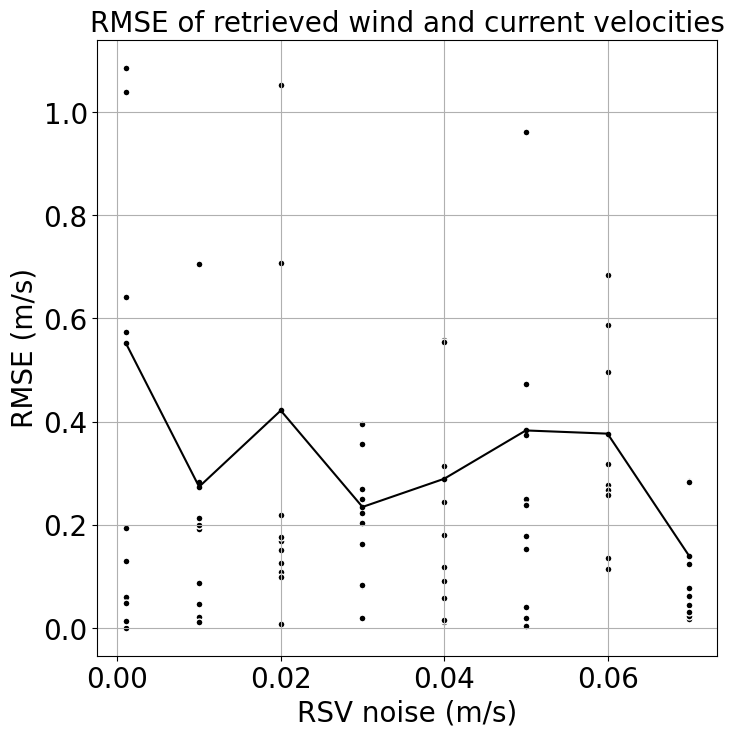

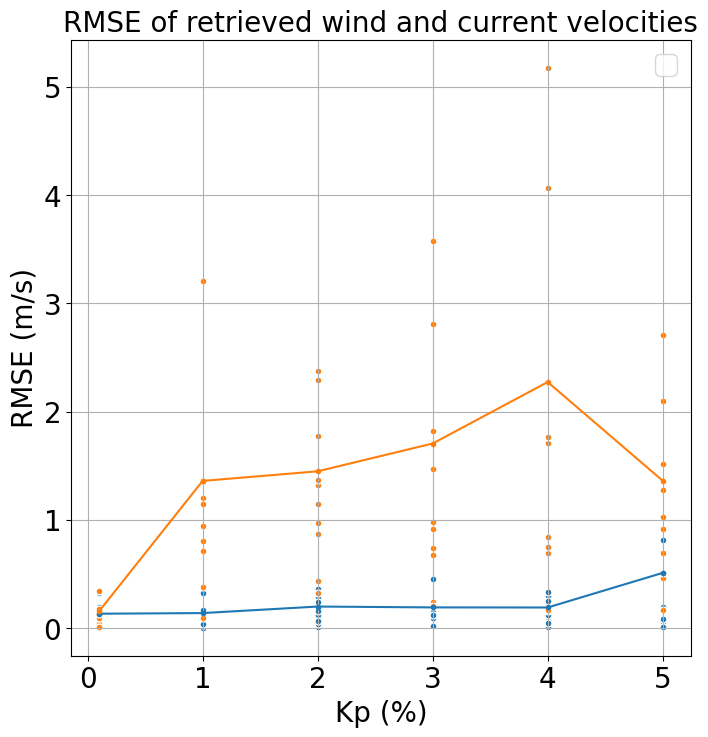

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)
np.sqrt(((L2_RSV_noise.CurrentVelocity - 0.6)**2).mean(dim='along')).plot(x='RSV_noise',
                                                                       marker='.', c='k'
                                                                      )
np.sqrt(((L2_RSV_noise.CurrentVelocity - 0.6)**2)).plot.scatter(x='RSV_noise',
                                                                marker='.', c='k',
                                                                s=100)
# np.sqrt(((L2_RSV_noise.WindSpeed - 5.)**2).mean(dim='along')).plot(x='RSV_noise',
#                                                                 marker='.', c='C1')
# np.sqrt(((L2_RSV_noise.WindSpeed - 5.)**2)).plot.scatter(x='RSV_noise',
#                                                                 marker='.', c='C1',
#                                                                 s=100,)
plt.xlabel('RSV noise (m/s)',fontsize=20)
plt.ylabel('RMSE (m/s)',fontsize=20)
plt.title('RMSE of retrieved wind and current velocities',
          fontsize=20)
plt.grid()
handles, labels = ax.get_legend_handles_labels()

# manually define a new patch 
# patch = mpatches.Patch(color='C0', label='Current velocity')
# handles.append(patch)
# patch = mpatches.Patch(color='C1', label='Wind Speed')
# handles.append(patch)
# plt.legend(handles=handles, loc='upper right')
plt.show()

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(1,1,1)
# np.sqrt(((L2_RSV_noise.CurrentDirection - 150)**2).mean(dim='along')).plot(x='RSV_noise',
#                                                                        marker='.', c='C0'
#                                                                       )
# np.sqrt(((L2_RSV_noise.CurrentDirection - 150)**2)).plot.scatter(x='RSV_noise',
#                                                                 marker='.', c='C0',
#                                                                 s=100)
# np.sqrt(((L2_RSV_noise.WindDirection - 360)**2).mean(dim='along')).plot(x='RSV_noise',
#                                                                 marker='.', c='C1')
# np.sqrt(((L2_RSV_noise.WindDirection - 360)**2)).plot.scatter(x='RSV_noise',
#                                                                 marker='.', c='C1',
#                                                                 s=100,)
# plt.xlabel('RSV noise (m/s)',fontsize=20)
# plt.ylabel('RMSE (degrees)',fontsize=20)
# plt.title('RMSE of retrieved wind and current directions',
#           fontsize=20)
# plt.grid()
# handles, labels = ax.get_legend_handles_labels()

# # manually define a new patch 
# patch = mpatches.Patch(color='C0', label='Current velocity')
# handles.append(patch)
# patch = mpatches.Patch(color='C1', label='Wind Speed')
# handles.append(patch)
# plt.legend(handles=handles, loc='upper right')
# plt.show()



fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)

np.sqrt(((L2_sigma0_noise.CurrentVelocity - 0.6)**2).mean(dim='along'))\
    .plot(x='sigma0_noise',marker='.', c='C0')
np.sqrt(((L2_sigma0_noise.CurrentVelocity - 0.6)**2))\
    .plot.scatter(x='sigma0_noise',marker='.', c='C0',s=100)
np.sqrt(((L2_sigma0_noise.WindSpeed - 5.)**2).mean(dim='along'))\
    .plot(x='sigma0_noise',marker='.', c='C1')
np.sqrt(((L2_sigma0_noise.WindSpeed - 5.)**2))\
    .plot.scatter(x='sigma0_noise',marker='.', c='C1',s=100,)

plt.xlabel('Kp (%)', fontsize=20)
plt.ylabel('RMSE (m/s)', fontsize=20)
plt.title('RMSE of retrieved wind and current velocities',
          fontsize=20)
plt.xticks(ticks=[0,0.01,0.02,0.03,0.04,0.05], labels=[0,1,2,3,4,5])
plt.grid()
# manually define a new patch 

plt.legend(handles=handles, loc='upper right')
plt.show()


# Plot RMdSE

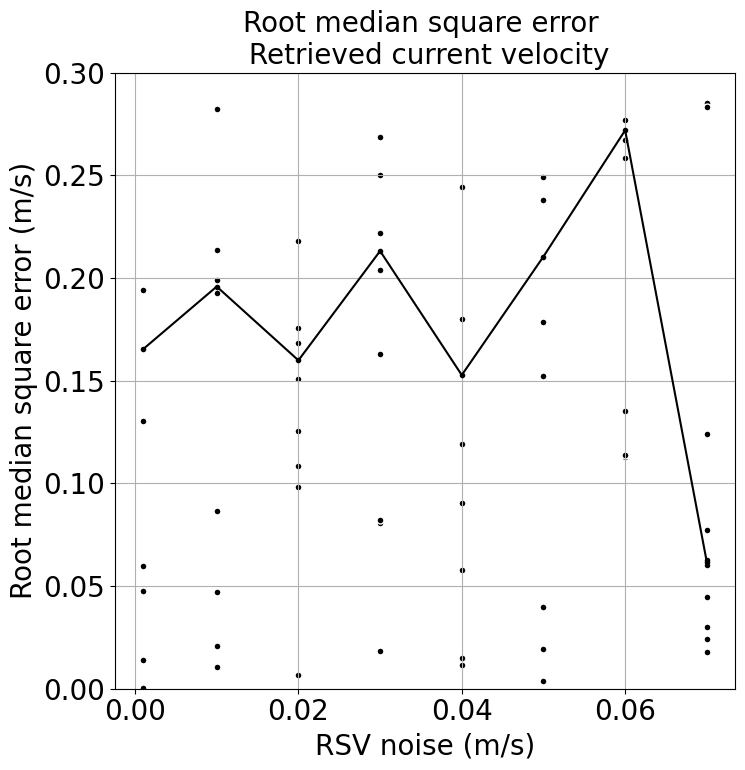

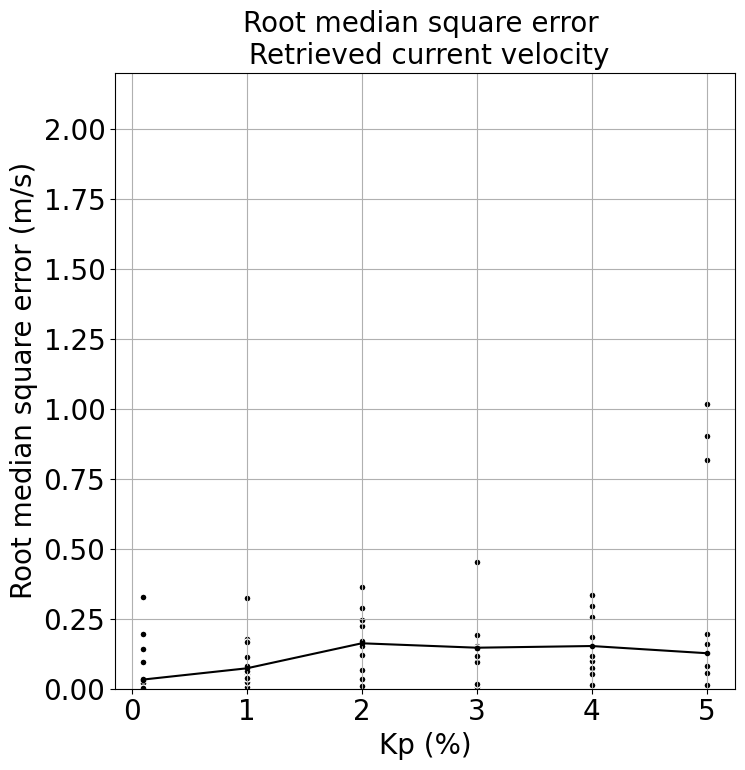

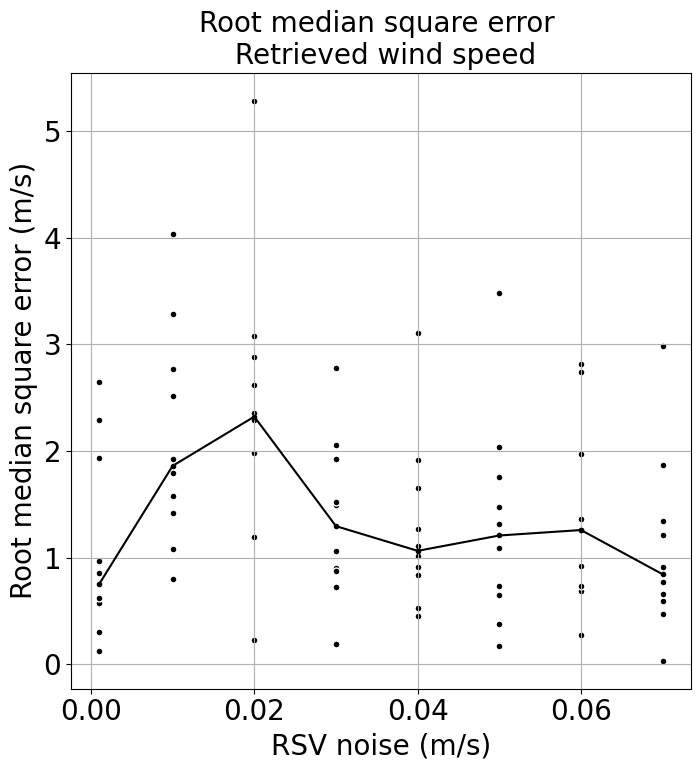

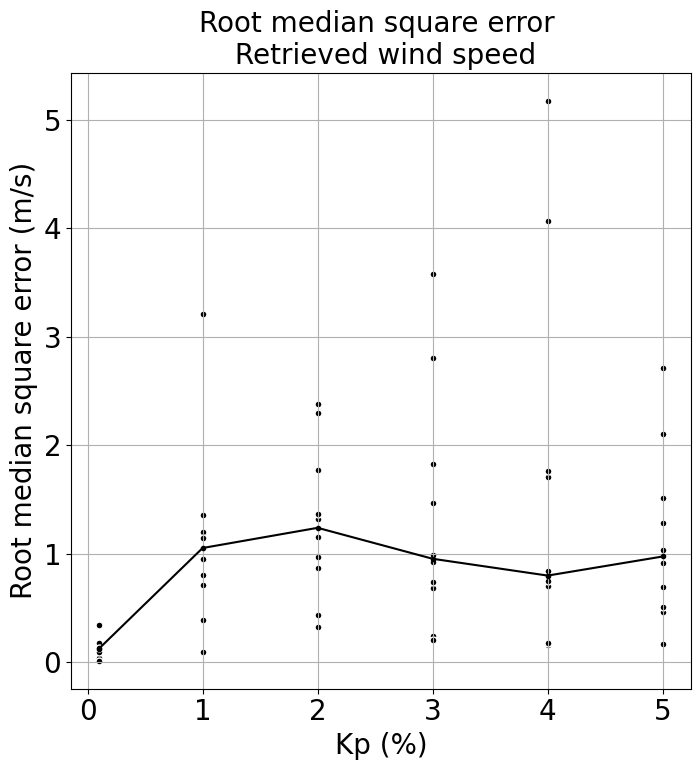

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)
np.sqrt(((L2_RSV_noise.CurrentVelocity - 0.6)**2).median(dim='along')).plot(x='RSV_noise',
                                                                       marker='.', c='k',
                                                                            ylim=[0,.3]
                                                                      )
np.sqrt(((L2_RSV_noise.CurrentVelocity - 0.6)**2)).plot.scatter(x='RSV_noise',
                                                                marker='.', c='k',
                                                                s=100)
# np.sqrt(((L2_RSV_noise.WindSpeed - 5.)**2).median(dim='along')).plot(x='RSV_noise',
#                                                                 marker='.', c='C1')
# np.sqrt(((L2_RSV_noise.WindSpeed - 5.)**2)).plot.scatter(x='RSV_noise',
#                                                                 marker='.', c='C1',
#                                                                 s=100,)
plt.xlabel('RSV noise (m/s)',fontsize=20)
plt.ylabel('Root median square error (m/s)',fontsize=20)
plt.title('Root median square error \n Retrieved current velocity',
          fontsize=20)
plt.grid()
# plt.legend(handles=handles, loc='upper right')
plt.show()



fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)

np.sqrt(((L2_sigma0_noise.CurrentVelocity - 0.6)**2).median(dim='along'))\
    .plot(x='sigma0_noise',marker='.', c='k', ylim=[0,2.2])
np.sqrt(((L2_sigma0_noise.CurrentVelocity - 0.6)**2))\
    .plot.scatter(x='sigma0_noise',marker='.', c='k',s=100)

# np.sqrt(((L2_sigma0_noise.WindSpeed - 5.)**2).median(dim='along'))\
#     .plot(x='sigma0_noise',marker='.', c='C1')
# np.sqrt(((L2_sigma0_noise.WindSpeed - 5.)**2))\
#     .plot.scatter(x='sigma0_noise',marker='.', c='C1',s=100,)

plt.xlabel('Kp (%)',fontsize=20)
plt.ylabel('Root median square error (m/s)',fontsize=20)
plt.title('Root median square error \n Retrieved current velocity',
          fontsize=20)
plt.xticks(ticks=[0,0.01,0.02,0.03,0.04,0.05], labels=[0,1,2,3,4,5])
plt.grid()
# plt.legend(handles=handles, loc='upper right')
plt.show()


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)
# np.sqrt(((L2_RSV_noise.CurrentVelocity - 0.6)**2).median(dim='along')).plot(x='RSV_noise',
#                                                                        marker='.', c='k',
#                                                                             ylim=[0,.3]
#                                                                       )
# np.sqrt(((L2_RSV_noise.CurrentVelocity - 0.6)**2)).plot.scatter(x='RSV_noise',
#                                                                 marker='.', c='k',
#                                                                 s=100)
np.sqrt(((L2_RSV_noise.WindSpeed - 5.)**2).median(dim='along')).plot(x='RSV_noise',
                                                                marker='.', c='k')
np.sqrt(((L2_RSV_noise.WindSpeed - 5.)**2)).plot.scatter(x='RSV_noise',
                                                                marker='.', c='k',
                                                                s=100,)
plt.xlabel('RSV noise (m/s)',fontsize=20)
plt.ylabel('Root median square error (m/s)',fontsize=20)
plt.title('Root median square error \n Retrieved wind speed',
          fontsize=20)
plt.grid()
# plt.legend(handles=handles, loc='upper right')
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)

# np.sqrt(((L2_sigma0_noise.CurrentVelocity - 0.6)**2).median(dim='along'))\
#     .plot(x='sigma0_noise',marker='.', c='k', ylim=[0,2.2])
# np.sqrt(((L2_sigma0_noise.CurrentVelocity - 0.6)**2))\
#     .plot.scatter(x='sigma0_noise',marker='.', c='k',s=100)

np.sqrt(((L2_sigma0_noise.WindSpeed - 5.)**2).median(dim='along'))\
    .plot(x='sigma0_noise',marker='.', c='k')
np.sqrt(((L2_sigma0_noise.WindSpeed - 5.)**2))\
    .plot.scatter(x='sigma0_noise',marker='.', c='k',s=100,)

plt.xlabel('Kp (%)',fontsize=20)
plt.ylabel('Root median square error (m/s)',fontsize=20)
plt.title('Root median square error \n Retrieved wind speed',
          fontsize=20)
plt.xticks(ticks=[0,0.01,0.02,0.03,0.04,0.05], labels=[0,1,2,3,4,5])
plt.grid()
# plt.legend(handles=handles, loc='upper right')
plt.show()


# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(1,1,1)
# np.sqrt(((L2_RSV_noise.CurrentDirection - 150)**2).median(dim='along')).plot(x='RSV_noise',
#                                                                        marker='.', c='k',
#                                                                             ylim=[0,.3]
#                                                                       )
# np.sqrt(((L2_RSV_noise.CurrentDirection - 150)**2)).plot.scatter(x='RSV_noise',
#                                                                 marker='.', c='k',
#                                                                 s=100)
# # np.sqrt(((L2_RSV_noise.WindSpeed - 5.)**2).median(dim='along')).plot(x='RSV_noise',
# #                                                                 marker='.', c='C1')
# # np.sqrt(((L2_RSV_noise.WindSpeed - 5.)**2)).plot.scatter(x='RSV_noise',
# #                                                                 marker='.', c='C1',
# #                                                                 s=100,)
# plt.xlabel('RSV noise (m/s)',fontsize=20)
# plt.ylabel('Root median square error (m/s)',fontsize=20)
# plt.title('Root median square error \n Retrieved current velocity',
#           fontsize=20)
# plt.grid()
# # plt.legend(handles=handles, loc='upper right')
# plt.show()



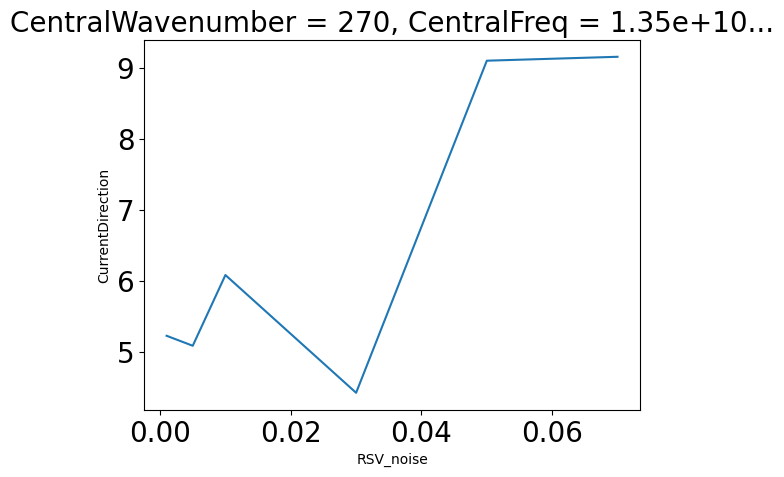

In [23]:
np.sqrt(((L2_RSV_noise.CurrentDirection-150)**2)).median(dim='along').plot()

In [132]:
("%03d" % (noise_RSV_list[0] *100))

'001'

In [35]:
round(geo.CurrentVelocity.mean().data*10)

6

In [37]:
save_filename = 'noisePerf_'+\
'3AC28_28_'+'001x'+("%03d" % (along_length))+'_'\
'SNKp'+str(0.001*100)+'RSV'+("%03d" % (noise_RSV_list[0] *100))+'_'+("%03d" % (noise_RSV_list[-1] *100))+'_'\
'MVNKp' + str(0.001*100)+'RSV'+str(100)+'_'\
'W'+("%03d" % (geo.WindSpeed.mean().data))+'_'+("%03d" % (geo.WindDirection.mean().data))+'_'+\
'C'+("%03d" % (round(geo.CurrentVelocity.mean().data*10)))+'_'+("%03d" % (geo.CurrentDirection.mean().data))+'_'+\
'N4DS_M12.nc'
save_filename

#W005_345_C0.6_150_N4DS_M12

'noisePerf_3AC28_28_001x020_SNKp0.1RSV000_007_MVNKp0.1RSV100_W004_003_C006_150_N4DS_M12.nc'

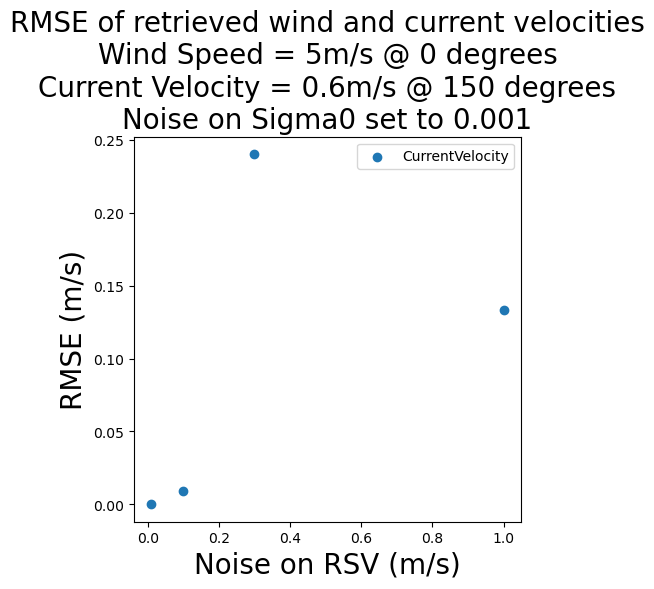

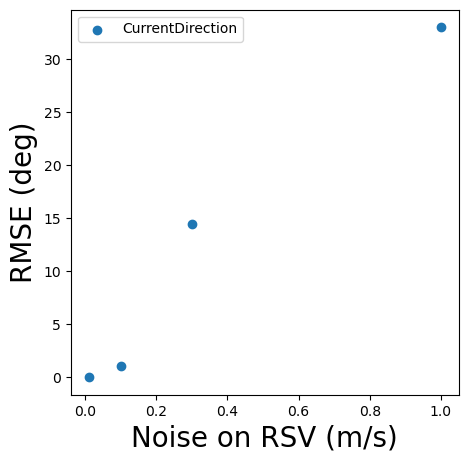

In [23]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)

plt.scatter(noise_RSV_list, WindSpeed_RMS, label='WindSpeed')
#plt.scatter(noise_RSV_list, CurrentVelocity_RMS, label='CurrentVelocity')
plt.xlabel('Noise on RSV (m/s)', fontsize=20)
plt.ylabel('RMSE (m/s)', fontsize=20)
plt.legend()
plt.title('RMSE of retrieved wind and current velocities\n'
          'Wind Speed = 5m/s @ 0 degrees\n'
          'Current Velocity = 0.6m/s @ 150 degrees\n'
          'Noise on Sigma0 set to 0.001',
          fontsize=20)
plt.show()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)

plt.scatter(noise_RSV_list, WindDirection_RMS, label='WindDirection')
#plt.scatter(noise_RSV_list, CurrentDirection_RMS, label='CurrentDirection')
plt.xlabel('Noise on RSV (m/s)', fontsize=20)
plt.ylabel('RMSE (deg)', fontsize=20)
plt.legend()


In [139]:
geo['EarthRelativeWindSpeed'] = geo.WindSpeed
geo['EarthRelativeWindDirection'] = geo.WindDirection

In [140]:
ss.utils.tools.EarthRelativeSpeedDir2all(geo)

<xarray.Dataset>
Dimensions:                     (along: 4)
Coordinates:
  * along                       (along) int32 0 1 2 3
Data variables: (12/14)
    WindSpeed                   (along) float64 5.0 5.0 5.0 5.0
    WindDirection               (along) float64 0.0 0.0 0.0 0.0
    CurrentVelocity             (along) float64 0.6 0.6 0.6 0.6
    CurrentDirection            (along) float64 150.0 150.0 150.0 150.0
    CurrentU                    (along) float64 0.3 0.3 0.3 0.3
    CurrentV                    (along) float64 -0.5196 -0.5196 -0.5196 -0.5196
    ...                          ...
    EarthRelativeWindU          (along) float64 3.062e-16 ... 3.062e-16
    EarthRelativeWindV          (along) float64 -5.0 -5.0 -5.0 -5.0
    OceanSurfaceWindU           (along) float64 -0.3 -0.3 -0.3 -0.3
    OceanSurfaceWindV           (along) float64 -4.48 -4.48 -4.48 -4.48
    OceanSurfaceWindSpeed       (along) float64 4.49 4.49 4.49 4.49
    OceanSurfaceWindDirection   (along) float64 3.831 3.831 3.831 3.831